# Tutorial 3b: Classification using simple statistics (ctd)

## Part b: Using statistical distance

### Mahalanobis distance--a simple classifier based on a calculated distance measure


Simpler is better. Even when applying more advanced ML classification techniques, one should always use a simple method to set a baseline for comparison.  All too often, researchers fail to do this--they may discover too late that their fancy methods are no better than very simple ones.

The simplest classification methods are based on elementary statistics.
One standard statistical classification method uses the so-called [*Mahalanobis distance*](https://en.wikipedia.org/wiki/Mahalanobis_distance). Given an (approximately normal) probability distribution, the Mahalanobis distance of a data point to that distribution uses the covariance matrix of the distribution to estimate the "likelihood" that that data point belongs to the distribution. So if we have two or more distributions and want to assign a data point to one of them, we may choose the distribution that gives the smallest Mahalanobis distance. One big advantage of Mahalanobis distance is that it can be used to classify data based on multiple features (unlike ROC curves, which only work for single-feature classification).

This classification is easy to program in Python. We will demonstrate on our classification of rooibos into fermented and nonfermented. Recall that our data is contained in the dataframe `df`, and the `type` column indicates nonfermented (0) or fermented (1).  We call this our `target output`, and record it in the variable `y`.

### Exercise 1 ### 
In the following code cell, repeat the imports from Tutorial 3a, including the necessary libraries and the data.  Display the first 10 rows of the `type` column in the dataframe. 

In [30]:
# ___Cell no. 1___ Exercise 1 here



In the remainder of this tutorial, we will construct a _pipeline_ for training and testing a classifier. The pipeline encodes a systematic procedure that takes data as input and produces an evaluation of a classifier (or several classifiers) as output. The pipeline also enables the possibility of comparing different versions of the same classifier.  This pipeline structure is very important, for several reasons.  First, it enables you to tune your machine learning algorithm by applying exactly the same procedure to multiple variants of the algorithm. Second, a well-constructed pipeline can be reused on other, similar data: this is very important in case you (or others) want to verify your results on another dataset. Finally, the pipeline can be slightly modified to evaluate other classifiers as well (as you'll see in Tutorial 4).

To begin  let us list the feature groups that we will use for classification. Each feature group will give us a different classifier. We will look at three single-feature groups and one with two features. 

In [31]:
# ___Cell no. 2___

featureSets = [ ['TPC_H2O'], ['TEAC_H2O'],['FRAP_H2O'], ['TPC_H2O', 'TEAC_H2O']]

At this point, we need to split the data between training data and testing data. The training data is used to  estimate the distribution parameters of fermented and nonfermented. Then, the testing data is used to evaluate the performance of the resulting classifiers.

There is no set rule for choosing the split between training and testing, although generally the training set is larger.  To see which split gives the most reliable classifier, we use <i>jackknife</i> which gives error bars for each estimator's accuracy.  Jackknife works by going through the training/testing process multiple times, each time leaving out one data sample.  This produces multiple accuracy estimates, which can be combined using the "jackknife formula" to obtain an estimate for the variance of the classifier's accuracy.  For more background on the jackknife method, see https://en.wikipedia.org/wiki/Jackknife_resampling. 

First we list the different splits that we will evaluate. Splits are specified according to the proportion of data that is used for testing, while the rest of the data is used for training. 

In [32]:
# ___Cell no. 3___

splits = [0.3,0.4]# Each number gives the proportion of testing data for a particular split

It is convenient to store the results in a *dictionary*.  A dictionary is a Python data structure consisting of key-value pairs. Just like in a regular dictionary, stored values are referenced by keyword, instead of using an index as in lists or arrays. 

In our case, we will create a *nested dictionary*, in which keys are assigned subkeys to label specific information. In our case, the top-level keys indicate the features, second-level keys give the training/testing split, and subkeys indicate different performance results obtained for each estimator.  For more information on nested dictionaries, see: https://www.geeksforgeeks.org/python-nested-dictionary/

First we define an empty dictionary to hold our results.

In [33]:
# ___Cell no. 4___

base_dict = {} 

The following code trains and evaluates 8 classifiers (4 feature sets with 2 splits per feature set).  The code produces the following outputs for each classifier:

* `tot_acc`    : total accuracy;
* `jack_trainSD` : jackknife estimate of standard deviation due to training variation 
* `jack_testSD`  : jackknife estimate of standard deviation due to testing variation
* `jack_totSD`: jackknife estimate of standard deviation due to both training and testing variation


To obtain all these outputs for multiple classifiers, we need some accessory functions.  First we define a function `acc_score_Maha` to compute the accuracy score for a Mahalanobis-distance based classifier with given training and testing sets. The code is below.

### Exercise 2.
Complete the following code. Incomplete portions are denoted by @@@.
(Leave the @@@ comments in the code so that I can check your code)

In [34]:
# ___Cell no. 5___

# Compute accuracy score for Mahalanobis-based estimator
# xtr, xtst are the training and testing data (dataframe format)
# ytr, ytst are the training and testing labels (dataframe format)
def acc_score_Maha(xtr,ytr,xtst,ytst):
        ncol = len(xtr.columns)
        # First, convert ytr to array to use as an index
        ytr = ytr.to_numpy().flatten()
        
        # Compute M-dist of testing data vectors to data 0
        # the result 'mahaDist0' is an array with the Mahalanobis distances for
        # each testing instance.
        # Select data with label 0
        xtr0 = xtr[ytr==0]
        #Covariance matrix of training data with label 0 
        xtrCov0 = xtr0.cov().to_numpy()
        #Shift of testing data by mean of data with label 0
        xtst0 = (xtst - xtr0.mean(axis=0)).to_numpy().reshape((-1,ncol))
        # Mahalanobis distance of testing data to data with label 0
        mahaDist0 = np.diag(xtst0 @ np.linalg.inv(xtrCov0) @ np.transpose(xtst0))
        
        # @@@ As in the above section, compute the Mahalanobis distances of 
        # @@@ testing instances to training data 1, and store in the variable 'mahaDist1'
                
        ## Algorithm determinantion of test set label
        # @@@ Create a vector 'yPred' with the same length as 'mahaDist0' and 'mahaDist1'
        # @@@ which is 0 or 1 depending on whether the test vector's distance is closer to 
        # @@@ label 0 or label 1
        
        # Reformat actual labels to compare with predicted
        yActual = ytst.to_numpy().flatten()
        # @@@ Return the proportion of correct predictions
        

Next, we define a function `get_accuracy_jack` which returns the accuracy score, plus the standard deviations on the accuracy due to training and testing error computed via jackknife using the leave-out-one accuracy scores:

### Exercise 3.
Complete the following code. Incomplete portions are marked with @@@.

In [35]:
# ___Cell no. 6___

def get_accuracy_jack(xTrain, yTrain, xTest, yTest):
    # Compute accuracy of overall data
    accTot = acc_score(xTrain, yTrain, xTest, yTest)
    
    # Compute jackknife estimates
    # Need number of estimates to define lists of results
    nxtr = len(yTrain)
    nxte=len(yTest)
    
    # Make space for lists of leave-out-one results
    jackTrainArr = [None]*nxtr
    jackTestArr = [None]*nxte
    
    # Compute accuracies for all leave-out-one train/test sets:
    # leave-out-one for training
    for jtr,itr in enumerate(list(xTrain.index)):
        x_train = xTrain.drop(index=itr)
        y_train = yTrain.drop(index=itr)
        jackTrainArr[jtr] = acc_score(x_train, y_train, xTest, yTest)
    
    # @@@ Compute leave out one for testing. Your result should be an array
    # @@@ jackTestArr which corresponds to jackTrainArr
    
    # Compute SD's for error due to training and testing via jackknife formula
    # The total SD is computed using the variance addition formula 
    # (training and testing errors are independent)
    jackTrainSD = np.sqrt((nxtr-1)*np.var(jackTrainArr))
    # @@@ Similarly compute jackTestSD 
    # @@@ Compute also jackTotSD which is the square root
    # @@@ of (training SD)**2 + (testing SD)**2.
    
    # Finished! return results
    return  accTot, jackTrainSD, jackTestSD,jackTotSD


Now we're ready to run tests of different splits and features to find the best alternative.  For this purpose, the following code is typical: we will use similar codes to optimize other hyperparameters (a hyperparameter is a number that determines how the algorithm will operate--another example of hyperparameter is learning rate).

### Exercise 4
Complete the following code. Incomplete portions are marked with @@@.

In [36]:
# ___Cell no. 7___

# This code computes accuracies for a binary classifier based on Mahalanobis distance
# with different train/test splits
# (https://en.wikipedia.org/wiki/Mahalanobis_distance)
from sklearn.model_selection import train_test_split

# Loop through different splits (use the same splits for all features)
for s in splits:
    # Create training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size= s, random_state=1, stratify = y, shuffle = True)
    # Set the top-level key
    key0 = str(s)
    # Create space for this key to store results
    base_dict[key0] = {}
    # Loop through features
    for f in featureSets:                    
        # Create keys in order to reference results
        key1=str(f) # Creates a top-level key for each estimator
 
        # @@@ Call "get_accuracy_jack" function for feature set f to perform train and test
        # @@@ Put the outputs in a list called "results"
        results = get_accuracy_jack (X_train[f], y_train, X_test[f], y_test) 
        
        # Index results according to sub-keys
        base_dict[key0][key1] = {} # Contains all results for this top-level key
        base_dict[key0][key1]['tot_acc'] = results[0]
        # @@@ Put the other three results using these subkeys:
        # @@@ 'jack_trainSD','jack_testSD','jack_totSD'
        
        # (optional) print output
        # print(base_dict)
        # print()

We may access different levels of the dictionary by using the keys

In [37]:
# ___Cell no. 8___

# All outputs for a particular split and feature set
print(base_dict["0.4"]["['FRAP_H2O']"]) 
# Individual output item
print(base_dict["0.3"]["['TPC_H2O']"]['jack_trainSD'])

{'tot_acc': 0.475, 'jack_train': 8.3820000221454525e-16, 'jack_test': 0.07996393417804525, 'jack_tot': 0.07996393417804525}
0.0


We may also display the nested key structure.

### Exercise 5: 
Complete the code below (same instructions as above)

In [38]:
# ___Cell no. 12___

print("Top level keys are:\n", base_dict.keys())
# @@@ Choose and print the first top-level key
# @@@ Print all subkeys under the first top-level key
# @@@ Print all sub-subkeys under the first subkey of the first top-level key


Top level keys are:
 dict_keys(['0.2', '0.4'])

 Subkeys are:
 dict_keys(["['TPC_H2O']", "['TEAC_H2O']", "['FRAP_H2O']", "['TPC_H2O', 'TEAC_H2O']"])

 Sub-subkeys are:
 dict_keys(['tot_acc', 'jack_train', 'jack_test', 'jack_tot'])


We store the dictionary to use in the next notebook.

In [39]:
# ___Cell no. 9___

%store base_dict 

Stored 'base_dict' (dict)


In preparation for plotting, we extract the accuracy and SD results from the dictionary and put into arrays. We can also print out the results.

### Exercise 6
Complete the following code. Same instructions as above.

In [40]:
# ___Cell no. 10___
class_name = []
acc_arr = [] 
sd_arr = [] 


for key0 in list(base_dict.keys()):
    for key1 in list(base_dict[key0].keys()):
        this_cn = str(key0)+','+str(key1)
        class_name.append(this_cn)
        # @@@ Extract the accuracy and standard deviation for the classifier
        # @@@ Corresponding to key0 and key1.  Append the accuracy to the list
        # @@@ acc_arr and append the std. dev. to the array sd_arr.

        # @@@ Print (and label) the classifier name, accuracy, and SD for this 
        # @@@ classifier. Your output should show all the classifiers.
 

Classifier name:0.2,['TPC_H2O', 'TEAC_H2O']
Estimated accuracy: 0.5
Standard deviation:0.11470786693528089

Classifier name:0.4,['TPC_H2O', 'TEAC_H2O']
Estimated accuracy: 0.475
Standard deviation:0.07996393417804525



The printed results are hard to interpret. It's much better to visualize using a graph. The `matplotlib` package `errorbar` makes it easy to plot error bars.

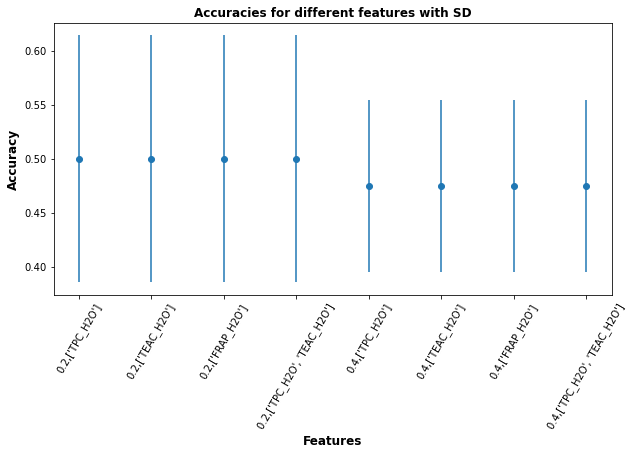

In [41]:
# ___Cell no. 11___

plt.figure(figsize=(10 , 5))
plt.title( "Accuracies for different features with SD", fontweight ='bold', fontsize =12)
plt.xlabel("Features", fontweight ='bold', fontsize =12)
plt.xticks(rotation = 60) # Rotates X-Axis Ticks by 45-degrees
plt.ylabel("Accuracy", fontweight ='bold', fontsize =12)
plt.errorbar( class_name, acc_arr, sd_arr, fmt='o')
plt.show()

**Exercise 5**:  Based on the above graph:
* Which of the better split:  40% testing or 30% testing? Justify your answer.
* Which feature set gives the most accurate classifier? Justify your answer.
---

It is very important to understand the meaning of the error bars. We do not know the actual accuracy of the classifiers: with more training and testing data, the accuracy estimate of any classifier will change. The error bars show the level of uncertainty in each classifier's accuracy.  In other words, if we do a more thorough test with more data, we expect to obtain an accuracy somewhere within the error bars. (We can also reduce the size of the error bars if we do more tests. 

In particular, the above graph shows that the `0.4,['TPC_H2O']` classifier is statistically worse than the `0.4,['TPC_H2O','TEAC_H2O']` classifier because their error bars do not overlap.  On the other hand, although it looks like `0.4,['TPC_H2O','TEAC_H2O']` is better than `0.4,['FRAP_H2O']`, still we cannot conclude that the difference between the two classifiers is statistically significant, because of the large error bars on the accuracy estimate for  `0.4,['FRAP_H2O']`.

### Exercise 7
 A. You have tried splits of 30% and 40%.  With the same features, try to find the best possible split. But don't go over 50%, because there are theoretical reasons that indicate that over 50% cannot be optimal.
 
 B. Repeat the same analysis  (and the same graphs) with the corresponding features using methanol instead of water.
 
 C. Compare water-based versus methanol-based estimators. Which give higher accuracy? Is this consistent?
 
 D. Take the best of the four water-based estimators, and compare with the other two estimators that are based on two features (TPC and FRAP, TEAC and FRAP). Which is the best?
 
 E. Repeat (D) with methanol-based estimators.
 
 F. Which is the overall best estimator of those we've seen so far?

### _The END of this notebook_
Just one more _

<img src="pics/bam.png" width="300" height="200">
